In [1]:
from kqeq.kernel import * # loading kernels and descriptors
from kqeq.kQEq import kernel_qeq, kQEq # kernel_qeq is class for training AND predictions, kQEq only for predictionf with a pretrained model 
from kqeq.funct import * # helping function, e.g. for obtaining hirshfeld charges

from ase.units import Hartree
from ase.io import read, write
from ase.visualize import view
import numpy as np


In [2]:
ZnOall = read("ZnObulk.xyz@:",format="extxyz")

In [3]:
ZnO2all = read("ZnO2bulk.xyz@:",format="extxyz")

In [4]:
ZnOwhole = ZnOall[:336]
ZnOvac = ZnOall[336:]

In [5]:
ZnO2whole = ZnO2all[:189]
ZnO2vac = ZnO2all[189:]

In [6]:
random.seed(20)
random.shuffle(ZnOwhole)
random.shuffle(ZnOvac)
random.shuffle(ZnO2whole)
random.shuffle(ZnO2vac)

In [7]:
print(len(ZnOwhole))
print(len(ZnOvac))
print(len(ZnO2whole))
print(len(ZnO2vac))

336
320
189
180


Following cell contains original code for the training from the paper. However, training would take longer. 

In [8]:
# train_set = ZnOwhole[:150]
# train_set.extend(ZnO2whole[:80])
# train_set.extend(ZnOvac[:150])
# train_set.extend(ZnO2vac[:80])

# test_set = ZnOwhole[150:]
# test_set.extend(ZnO2whole[80:])
# test_set.extend(ZnOvac[150:])
# test_set.extend(ZnO2vac[80:])


In [9]:
train_set = ZnOwhole[:5]
train_set.extend(ZnO2whole[:5])
train_set.extend(ZnOvac[:5])
train_set.extend(ZnO2vac[:5])

test_set = ZnOwhole[5:10]
test_set.extend(ZnO2whole[5:10])
test_set.extend(ZnOvac[5:10])
test_set.extend(ZnO2vac[5:10])


In [10]:
atom_energy = {"Zn": -49117.02929728, 
               "O": -2041.3604}

hard_lib = {"O": 1, "Zn": 1}


species = np.unique([spec  for mol in train_set for spec in  mol.get_chemical_symbols()])

In [11]:
desdictSOAP = {"nmax": 5,
           "lmax": 3,
           "rcut": 3.0,
           "sigma": 3.0/8,
           "species":species,
           "periodic": True} 


SOAP_Kernel = SOAPKernel(multi_SOAP=False,
                         descriptor_dict=desdictSOAP, 
                         training_set=train_set,
                         training_system_charges=[0 for a in train_set],
                         sparse=True,
                         sparse_count=1000,
                         perEl = False,
                         sparse_method = "CUR")

# SOAP_Kernel = SOAPKernel(multi_SOAP=False,
#                          descriptor_dict=desdictSOAP,
#                          perEl = False,
#                          sparse=True)


In [12]:
# Energy of the training set
ref_en_train = get_energies(mols=train_set,atom_energy = atom_energy)

# # Create an instance of the kQEq class
my_kqeq = kernel_qeq(Kernel=SOAP_Kernel,
                     scale_atsize=1.0/np.sqrt(2),
                     radius_type="qeq",
                     hard_lib = hard_lib,
                    periodic=True)


# my_kqeq = kQEq(Kernel=SOAP_Kernel,
#                      scale_atsize=1.0/np.sqrt(2),
#                      radius_type="qeq",
#                      hard_lib = hard_lib,
#                     periodic=True)

In [13]:
# # my_kqeq.load_kQEq(nameW="weightsNewZnO2.npy",nameS="sparseSOAPNewZnO2.npy")
my_kqeq.trainEnCharge(atom_energy=atom_energy,
                      charge_keyword="hirshfeld", 
                      lambda_reg = 0.01,
                      lambda_charges=  0.1,
                      lambda_charges_min=0.01,
                      max_iter = 100,
                      iter_charges = 2)
# my_kqeq.load_kQEq()

####################################################################
New RMSE: 20.920426458609466
Old RMSE: 10000
Bad RMSEs in row: 1
Sample of charges: [-0.47080138 -0.47078921 -0.49053802 -0.49129462 -0.49067834 -0.49042942
 -0.50977781 -0.50979168 -0.302159   -0.30192208]
iteration 0 is done
####################################################################
####################################################################
New RMSE: 2.1011128237931156
Old RMSE: 20.920426458609466
Bad RMSEs in row: 1
Sample of charges: [-0.40184075 -0.40184638 -0.39150017 -0.39196173 -0.39155712 -0.39135911
 -0.40457171 -0.40458119 -0.30796799 -0.30763879]
iteration 1 is done
####################################################################
####################################################################
New RMSE: 0.03958588870807569
Old RMSE: 2.1011128237931156
Bad RMSEs in row: 1
Sample of charges: [-0.39950362 -0.39951626 -0.38099728 -0.38138588 -0.38102795 -0.38084441
 -0.3924158  -0.3

In [14]:
# my_kqeq.save_kQEq()  

In [15]:
E_train = []
q_train = []
for a in train_set:
    res = my_kqeq.calculatePeriodic(a)
    E_train.append(res["energy"]/len(a))
    q_train.extend(res["charges"])
ref_en_train = get_energies_perAtom(mols=train_set,atom_energy = atom_energy)
ref_q_train = get_charges(train_set,charge_keyword = "hirshfeld")

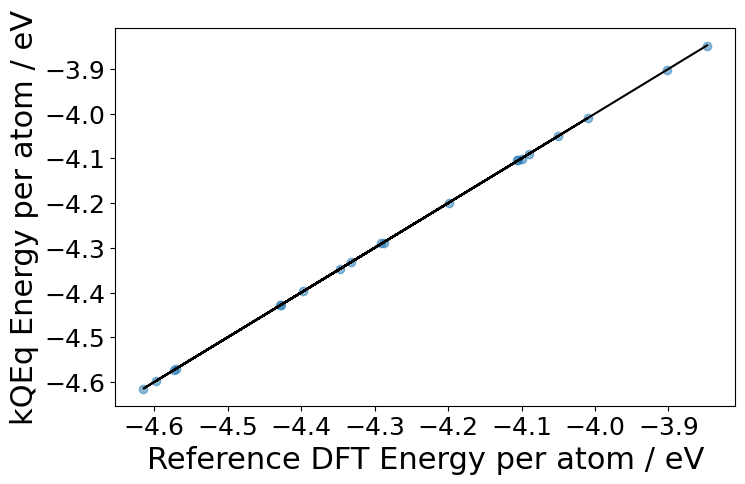

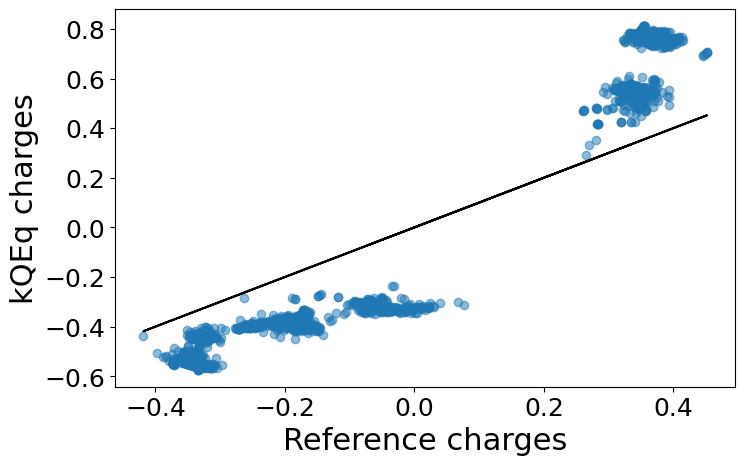

In [16]:

ref_q_test = get_charges(test_set,charge_keyword = "hirshfeld")
ref_q_train = get_charges(train_set,charge_keyword = "hirshfeld")
plot_basics(ref_en_train,E_train,preset="energy",save="trainE.png")
plot_basics(ref_q_train,q_train,preset="charges",save="trainq.png")
# view(train_set)

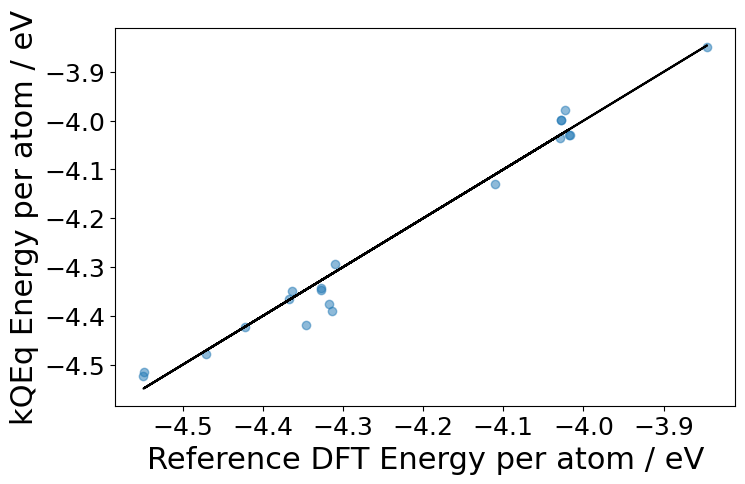

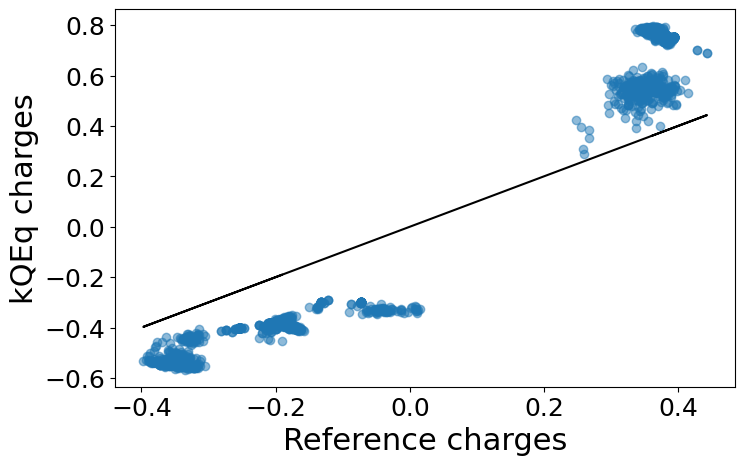

In [17]:
E_test = []
q_test = []
for a in test_set:
    res = my_kqeq.calculatePeriodic(a)
    E_test.append(res["energy"]/len(a))
    q_test.extend(res["charges"])
ref_en_test = get_energies_perAtom(mols=test_set,atom_energy = atom_energy)
ref_q_test = get_charges(test_set,charge_keyword = "hirshfeld")


ref_q_test = get_charges(test_set,charge_keyword = "hirshfeld")
ref_q_train = get_charges(train_set,charge_keyword = "hirshfeld")
plot_basics(ref_en_test,E_test,preset="energy",save="trainE.png")
plot_basics(ref_q_test,q_test,preset="charges",save="trainq.png")
# view(train_set)

In [18]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(ref_en_test, E_test, squared=False)
print(rms)

0.03313487044623903
